In [1]:
## Integrate Nashville, Chicago and Munich Cohort (input: filtered, raw count matrices)
import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc
import pandas as pd
import seaborn as sb
import datetime, time

# Some custom functions
import ma_codes as codes
from ma_codes import mysize, mymap

folder = "/191118_MLT-ASK_multiomics/"

sc.settings.verbosity = 3               # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_version_and_date()

Running Scanpy 1.4.5.dev186+g02fdd50e, on 2019-12-16 16:08.


### Munich Cohort

In [2]:
## Most current human data set
munich = sc.read(folder + "munich_cohort_raw_counts.h5ad")
munich

AnnData object with n_obs × n_vars = 38648 × 32104 
    obs: 'identifier', 'grouping', 'batch', 'patients', 'n_counts', 'n_genes', 'percent.mito', 'S_score', 'G2M_score', 'phase', 'louvain', 'cell_type', 'cell_state_label'
    var: 'n_cells', 'highly_variable', 'n_counts'
    uns: 'cell_state_label_colors', 'cell_type_colors', 'grouping_colors', 'identifier_colors', 'louvain', 'louvain_colors', 'neighbors', 'patients_colors', 'pca', 'rank_genes_groups'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'

In [4]:
## extract only raw counts
from scipy import sparse
obs = munich.obs
obs_names = munich.obs_names
var = munich.var_names.copy()

munich = sc.AnnData(X = sparse.csr_matrix(human[obs_names].layers["counts"]))
munich.obs_names = obs_names
munich.var_names = var
munich.obs = obs
munich

AnnData object with n_obs × n_vars = 38648 × 32104 
    obs: 'identifier', 'grouping', 'batch', 'patients', 'n_counts', 'n_genes', 'percent.mito', 'S_score', 'G2M_score', 'phase', 'louvain', 'cell_type', 'cell_state_label'

### Scran Normalize Schiller Data [Munich Cohort]

In [7]:
#Perform a clustering for scran normalization in clusters
adata_pp = munich.copy()
sc.pp.normalize_per_cell(adata_pp, counts_per_cell_after = 1e6)
sc.pp.log1p(adata_pp)
sc.pp.highly_variable_genes(adata_pp, flavor = 'cell_ranger', n_top_genes = 4000, subset = False)

sc.pp.pca(adata_pp, n_comps = 15, use_highly_variable = True)
sc.pp.neighbors(adata_pp)

normalizing by total count per cell
    finished (0:00:08): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:03)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA with n_comps = 15
computing PCA on highly variable genes
    finished (0:00:04)
computing neighbors
    using 'X_pca' with n_pcs = 15


/home/agando/anaconda3/lib/python3.6/site-packages/numba/compiler.py:588: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../anaconda3/lib/python3.6/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  self.func_ir.loc))
/home/agando/anaconda3/lib/python3.6/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../anaconda3/lib/python3.6/site-packages/um

    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:09)


In [8]:
sc.tl.louvain(adata_pp, key_added = 'groups', resolution = 1)

#Preprocess variables for scran normalization
input_groups = adata_pp.obs['groups']
data_mat = human.X.T

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 23 clusters and added
    'groups', the cluster labels (adata.obs, categorical) (0:00:06)


In [9]:
from rpy2.robjects import pandas2ri
pandas2ri.activate()
%load_ext rpy2.ipython
start = codes.timestamp()

In [12]:
%%R -i data_mat -i input_groups -o size_factors
suppressPackageStartupMessages(library(scran))

print(dim(data_mat))
size_factors = computeSumFactors(data_mat, clusters = input_groups, min.mean = 0.1)

[1] 32104 38648


In [13]:
print("Started Normalization\t%s" %start)
print("Finished Normalization\t%s" %codes.timestamp())

Started Normalization	14-12-2019 12:11:53
Finished Normalization	14-12-2019 12:33:17


In [17]:
## Delete adata_pp
del adata_pp

#Keep the count data in a counts layer (before normalization !)
munich.layers["counts"] = sc.AnnData(X = sparse.csr_matrix(munich.X))  ## don’t make a adata here...

## Normalize adata and Log Transform
munich.X /= munich.obs['size_factors'].values[:,None]
sc.pp.log1p(munich)

# Store the full data set in 'raw' as log-normalised data for statistical testing (e.g. Marker Genes)
munich.raw = human

/home/agando/anaconda3/lib/python3.6/site-packages/anndata/core/alignedmapping.py:162: UserWarning: AnnData does not currently support writing or reading of 'AnnData' objects in layers for either hdf5 or zarr formats.
  self._validate_value(value, key)


In [27]:
## Save this sparse, scran normalized matrix
munich.write(folder + "schiller_scran_normalized.h5ad")

### SCRAN Normalize Reyfman Data

In [2]:
raw_folder = "/media/agando/578222DA06535F39/Denver_Transfer/"
reyfman = sc.read(raw_folder + "reyfman.h5ad")
reyfman

AnnData object with n_obs × n_vars = 80919 × 33694 
    obs: 'nGene', 'nUMI', 'orig.ident', 'identifier', 'identifier.1', 'grouping', 'batch', 'cells', 'res.2'

In [4]:
## Perform a clustering for scran normalization in clusters
adata_pp = reyfman.copy()
sc.pp.normalize_per_cell(adata_pp, counts_per_cell_after = 1e6)
sc.pp.log1p(adata_pp)

normalizing by total count per cell
    finished (0:00:01): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


In [5]:
sc.pp.highly_variable_genes(adata_pp, flavor = 'seurat', n_top_genes = 4000, subset = False)

sc.pp.pca(adata_pp, n_comps = 15, svd_solver="arpack", use_highly_variable = True)
sc.pp.neighbors(adata_pp)

extracting highly variable genes
    finished (0:00:04)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA with n_comps = 15
computing PCA on highly variable genes
    finished (0:00:09)
computing neighbors
    using 'X_pca' with n_pcs = 15


/home/agando/anaconda3/lib/python3.6/site-packages/numba/compiler.py:588: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../anaconda3/lib/python3.6/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  self.func_ir.loc))
/home/agando/anaconda3/lib/python3.6/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../anaconda3/lib/python3.6/site-packages/um

    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:15)


In [6]:
sc.tl.louvain(adata_pp, key_added = 'groups', resolution = 1)

#Preprocess variables for scran normalization
input_groups = adata_pp.obs['groups']
data_mat = reyfman.X.toarray().T

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 27 clusters and added
    'groups', the cluster labels (adata.obs, categorical) (0:00:24)


In [7]:
from rpy2.robjects import pandas2ri
pandas2ri.activate()
%load_ext rpy2.ipython
start = codes.timestamp()

In [8]:
%%R -i data_mat -i input_groups -o size_factors
suppressPackageStartupMessages(library(scran))

print(dim(data_mat))
size_factors = computeSumFactors(data_mat, clusters = input_groups, min.mean = 0.1)

[1] 33694 80919


In [9]:
print("Started Normalization\t%s" %start)
print("Finished Normalization\t%s" %codes.timestamp())

Started Normalization	14-12-2019 13:41:05
Finished Normalization	14-12-2019 14:27:28


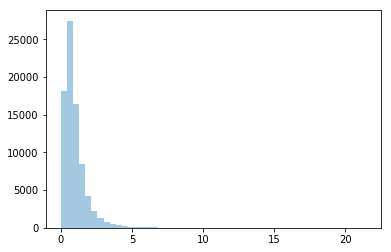

In [10]:
# Visualize the estimated size factors
reyfman.obs['size_factors'] = size_factors
sb.distplot(size_factors, bins = 50, kde = False)
plt.show()

In [11]:
from scipy import sparse

#Keep the count data in a counts layer (before normalization !)
reyfman.layers["counts"] = sparse.csr_matrix(reyfman.X)

## Normalize adata and Log Transform
reyfman.X /= reyfman.obs['size_factors'].values[:,None]
sc.pp.log1p(reyfman)

# Store the full data set in 'raw' as log-normalised data for statistical testing (e.g. Marker Genes)
reyfman.raw = reyfman

In [19]:
reyfman.raw = sc.AnnData(X = sparse.csr_matrix(reyfman.raw.X))
reyfman.X = sparse.csr_matrix(reyfman.X)

In [37]:
reyfman.write(folder + "reyfman_scran_normalized.h5ad")

### Variable Gene Selection

In [2]:
reyfman = sc.read(folder + "reyfman_scran_normalized.h5ad")
reyfman

AnnData object with n_obs × n_vars = 80919 × 33694 
    obs: 'nGene', 'nUMI', 'orig.ident', 'identifier', 'identifier.1', 'grouping', 'batch', 'cells', 'res.2', 'size_factors'
    layers: 'counts'

In [ ]:
sc.pp.highly_variable_genes(reyfman, batch_key = "orig.ident", n_bins = 20, n_top_genes = None,
                            flavor = "cell_ranger", subset = False)

In [ ]:
vartab = pd.DataFrame(reyfman.var["highly_variable_nbatches"], index = reyfman.var_names)

### Genes Variable in Munich Data Set

In [ ]:
sc.pp.highly_variable_genes(munich, batch_key = "patients", n_top_genes = None,
                            n_bins = 20, flavor = "cell_ranger", subset = False)
vartab_munich = pd.DataFrame(munich.var["highly_variable_nbatches"], index = munich.var_names)

### Take variable in at least 3 for reyfman, variable in at least 2 for munich

In [53]:
hvgs = vartab_munich[vartab_munich.highly_variable_nbatches.values > 1].index
hvgs = np.intersect1d(hvgs, vartab[vartab.highly_variable_nbatches.values > 2].index)
len(hvgs)

3971

In [56]:
## Remove ambient genes from this list
ambis = pd.read_csv(folder + "191216_ambients.txt", header = None)
ambis = [a for a in np.unique(ambis) if not a.startswith("muc")]

## Remove cell cycle genes from list - Human
cc_genes = [x.strip() for x in open(folder + "regev_lab_cell_cycle_genes.txt")]

remove = np.unique(np.concatenate([ambis, cc_genes]))
hvgs = np.setdiff1d(hvgs, remove)

### Regression of Munich Cohort

In [28]:
## Calculate cell cycle score
s_genes = cc_genes[:43]
g2m_genes = cc_genes[43:]
cc_genes = np.intersect1d(munich.var_names, cc_genes)
sc.tl.score_genes_cell_cycle(munich, s_genes = s_genes, g2m_genes = g2m_genes)

calculating cell cycle phase
computing score 'S_score'
    finished: added
    'S_score', score of gene set (adata.obs) (0:00:02)
computing score 'G2M_score'
    finished: added
    'G2M_score', score of gene set (adata.obs) (0:00:02)
-->     'phase', cell cycle phase (adata.obs)


In [ ]:
## Regress out percentage of mitochondrial genes and total UMI counts, as well as Cell Cycle
sc.pp.regress_out(munich, ['n_counts', 'percent.mito', 'S_score', 'G2M_score'])

### Regression of Reyfman Data

In [28]:
## Calculate cell cycle score
cc_genes = [x.strip() for x in open(folder + "regev_lab_cell_cycle_genes.txt")]

s_genes = cc_genes[:43]
g2m_genes = cc_genes[43:]
cc_genes = np.intersect1d(reyfman.var_names, cc_genes)
sc.tl.score_genes_cell_cycle(reyfman, s_genes = s_genes, g2m_genes = g2m_genes)

calculating cell cycle phase
computing score 'S_score'
    finished: added
    'S_score', score of gene set (adata.obs) (0:00:02)
computing score 'G2M_score'
    finished: added
    'G2M_score', score of gene set (adata.obs) (0:00:02)
-->     'phase', cell cycle phase (adata.obs)


In [ ]:
## Regress out percentage of mitochondrial genes and total UMI counts, as well as Cell Cycle
sc.pp.regress_out(reyfman, ['n_counts', 'percent.mito', 'S_score', 'G2M_score'])

### Preprocessing of Nashville Cohort

In [2]:
nash = sc.read(folder + "banovich.h5ad")
nash

AnnData object with n_obs × n_vars = 114396 × 33694 
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Diagnosis', 'Sample_Name', 'Sample_Source', 'Status', 'percent.mt', 'nCount_SCT', 'nFeature_SCT', 'seurat_clusters', 'population', 'celltype'

### Calculate cell cycle Score

In [34]:
## Calculate cell cycle score
s_genes = cc_genes[:43]
g2m_genes = cc_genes[43:]
cc_genes = np.intersect1d(nash.var_names, cc_genes)
sc.tl.score_genes_cell_cycle(nash, s_genes = s_genes, g2m_genes = g2m_genes)

calculating cell cycle phase
computing score 'S_score'
    finished: added
    'S_score', score of gene set (adata.obs) (0:00:02)
computing score 'G2M_score'
    finished: added
    'G2M_score', score of gene set (adata.obs) (0:00:02)
-->     'phase', cell cycle phase (adata.obs)


### Already subset here to highly variable genes used in Chicago + Munich merged data set

In [6]:
## Read in variable gene lists
vartab_s = pd.read_csv(folder + "schiller_variable_in_patients.txt", sep = "\t", index_col = 0)
vartab_r = pd.read_csv(folder + "reyfman_variable_in_patients.txt", sep = "\t", index_col = 0)

In [8]:
hvgs = vartab_s[vartab_s.highly_variable_nbatches.values > 1].index
hvgs = np.intersect1d(hvgs, vartab_r[vartab_r.highly_variable_nbatches.values > 2].index)

## Remove ambient genes from this list
ambis = pd.read_csv(folder + "191216_ambients.txt", header = None)
ambis = [a for a in np.unique(ambis) if not a.startswith("muc")]

## Remove cell cycle genes from list
cc_genes = [x.strip() for x in open(folder + "regev_lab_cell_cycle_genes.txt")]

remove = np.unique(np.concatenate([ambis, cc_genes]))
hvgs = np.setdiff1d(hvgs, remove)
nash.var["highly_variable"] = [g in hvgs for g in bano.var_names]
sum(bano.var["highly_variable"])

3854

In [14]:
## Subset to only these variable genes
genes = nash.var["highly_variable"]
nash._inplace_subset_var(genes)
nash.shape

(114396, 3854)

In [15]:
#Perform a clustering for scran normalization in clusters
adata_pp = nash.copy()
sc.pp.normalize_per_cell(adata_pp, counts_per_cell_after = 1e6)
sc.pp.log1p(adata_pp)

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


In [16]:
sc.pp.highly_variable_genes(adata_pp, flavor = 'seurat', n_top_genes = 4000, subset = False)

sc.pp.pca(adata_pp, n_comps = 15, svd_solver="arpack", use_highly_variable = True)
sc.pp.neighbors(adata_pp)
sc.tl.louvain(adata_pp, key_added = 'groups', resolution = 1)

#Preprocess variables for scran normalization
input_groups = adata_pp.obs['groups']
data_mat = bano.X.toarray().T

extracting highly variable genes
`n_top_genes` > `adata.n_var`, returning all genes.
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA with n_comps = 15
computing PCA on highly variable genes
    finished (0:00:11)
computing neighbors
    using 'X_pca' with n_pcs = 15


/home/agando/anaconda3/lib/python3.6/site-packages/numba/compiler.py:588: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../anaconda3/lib/python3.6/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  self.func_ir.loc))
/home/agando/anaconda3/lib/python3.6/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../anaconda3/lib/python3.6/site-packages/um

    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:21)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 23 clusters and added
    'groups', the cluster labels (adata.obs, categorical) (0:00:51)


In [17]:
from rpy2.robjects import pandas2ri
pandas2ri.activate()
%load_ext rpy2.ipython
start = codes.timestamp()

In [18]:
%%R -i data_mat -i input_groups -o size_factors
suppressPackageStartupMessages(library(scran))

print(dim(data_mat))
size_factors = computeSumFactors(data_mat, clusters = input_groups, min.mean = 0.1)

[1]   3854 114396


In [19]:
print("Started Normalization\t%s" %start)
print("Finished Normalization\t%s" %codes.timestamp())

Started Normalization	16-12-2019 20:19:13
Finished Normalization	16-12-2019 20:53:27


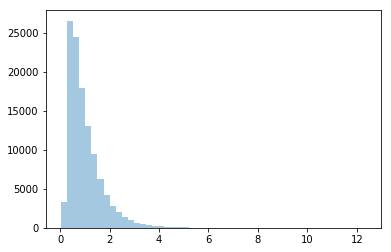

In [20]:
# Visualize the estimated size factors
nash.obs['size_factors'] = size_factors
sb.distplot(size_factors, bins = 50, kde = False)
plt.show()

In [23]:
## Normalize adata and Log Transform
nash.X /= nash.obs['size_factors'].values[:,None]
sc.pp.log1p(nash)

### Regression

In [ ]:
## Regress out percentage of mitochondrial genes and total UMI counts, as well as Cell Cycle
sc.pp.regress_out(nash, ['n_counts', 'percent.mito', 'S_score', 'G2M_score'])

### Merge the three separately processed Cohorts

In [3]:
adata = munich.concatenate([nash, reyfman], batch_key = "study", join = "outer", index_unique = None)
adata

AnnData object with n_obs × n_vars = 233963 × 3854 
    obs: 'Diagnosis', 'G2M_score', 'S_score', 'Sample_Name', 'Sample_Source', 'Status', 'all_patients', 'batch', 'cell_state_label', 'cell_type', 'cells', 'celltype', 'grouping', 'identifier', 'identifier.1', 'louvain', 'nCount_RNA', 'nCount_SCT', 'nFeature_RNA', 'nFeature_SCT', 'nGene', 'nUMI', 'n_counts', 'n_genes', 'orig.ident', 'patients', 'percent.mito', 'percent.mt', 'phase', 'population', 'res.2', 'seurat_clusters', 'size_factors', 'study'
    var: 'highly_variable-0', 'highly_variable-1'

In [19]:
adata.obs.data_set.value_counts()

Banovich    114396
Reyfman      80919
Schiller     38648
Name: data_set, dtype: int64

### Add cell type ids from manual annotation

In [ ]:
## Read in cell type IDs from Christoph (EPCAM subset)
marker = pd.read_csv(folder + "SchiReyBan_cell_types.txt", sep = "\t", header = None, index_col = 0)
marker.columns = ["cell_type"]
adata.obs["cell_type"] = [marker.loc[i].values[0] for i in adata.obs_names]

computing PCA with n_comps = 60
    finished (0:00:57)


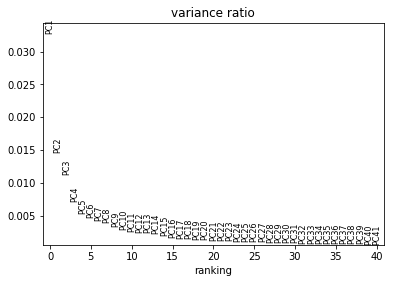

In [20]:
## Regressed - Scaled all at once
sc.pp.scale(adata)
sc.pp.pca(adata, n_comps = 60, use_highly_variable = False, svd_solver = "arpack")
sc.pl.pca_variance_ratio(adata, n_pcs = 40)

--> added to `.uns['neighbors']`
	'distances', weighted adjacency matrix
	'connectivities', weighted adjacency matrix
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 10 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:39:56)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:10:26)


... storing 'cell_type' as categorical


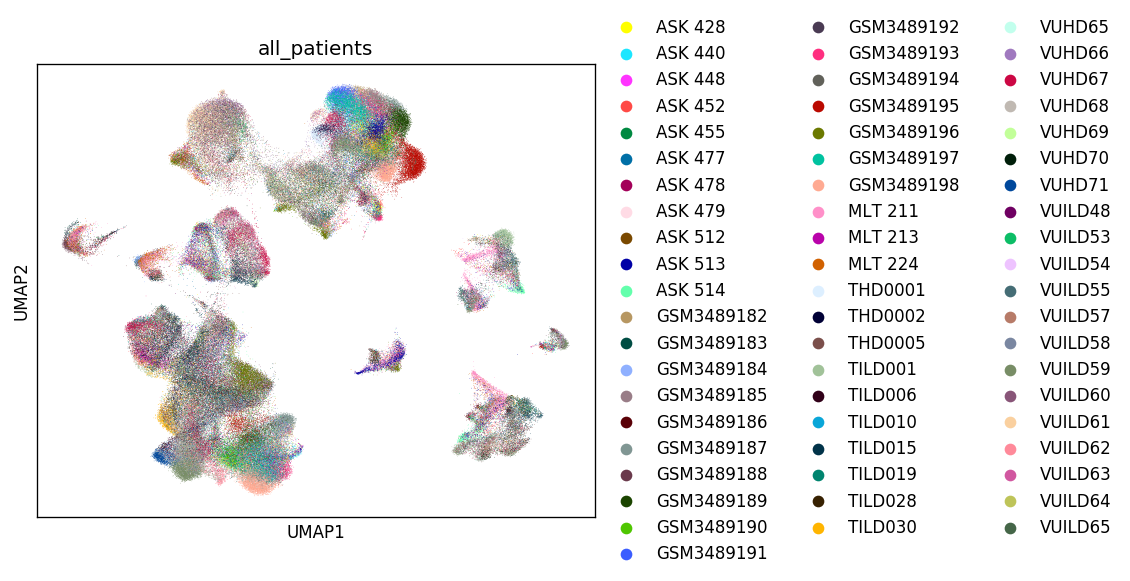

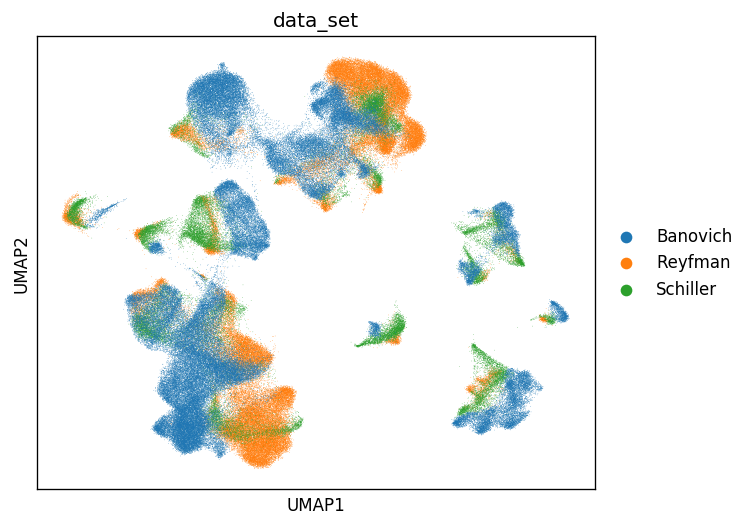

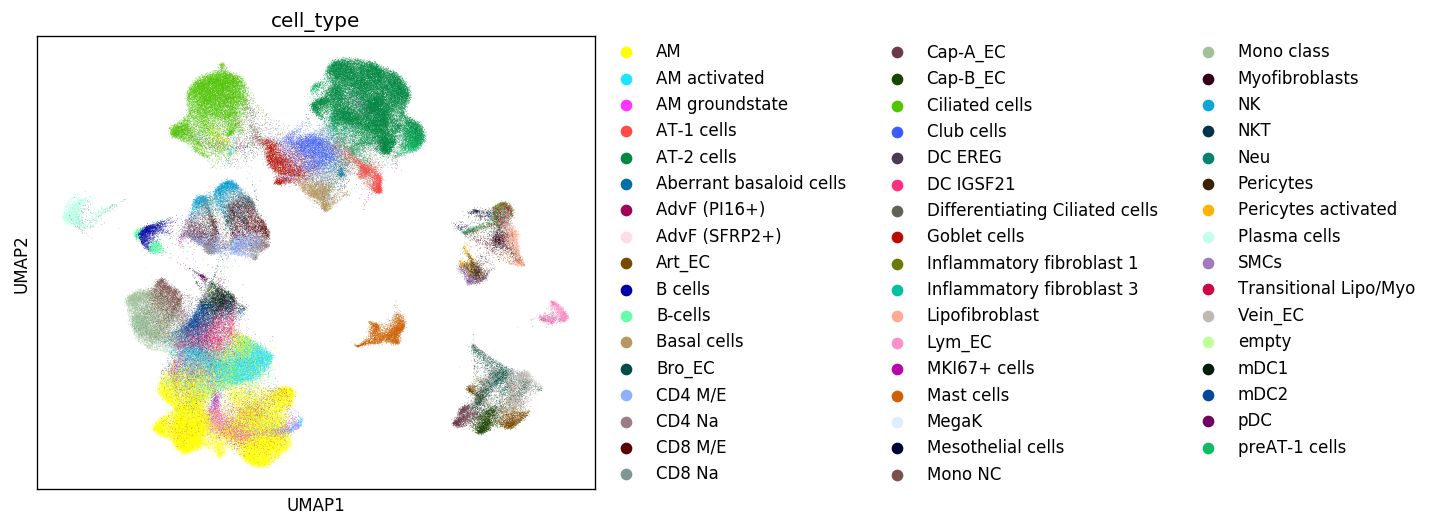

In [21]:
import bbknn

bbknn.bbknn(adata, batch_key = "all_patients", neighbors_within_batch = 10, n_pcs = 40)
sc.tl.louvain(adata, resolution = 1)
sc.tl.umap(adata)

sc.pl.umap(adata, color = "all_patients", ax = mysize(6, 5, 120))
sc.pl.umap(adata, color = "data_set", ax = mysize(6, 5, 120))
sc.pl.umap(adata, color = "cell_type", ax = mysize(6, 5, 120))

In [ ]:
adata.write(folder + "integrated_human_dataset.h5ad")